# Atividade 3
# O Problema do Caixeiro Viajante:
# Solução por Simulated Annealing

### Thaís Ferreira da Silva - 2021092571

In [73]:
# Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numba import jit
from typing import Tuple

### Funções do Roteiro
Código fornecido no enunciado para resolução do problema

In [74]:
@jit(nopython=True)
def distancias(N, x, y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt(np.power((x[i] - x[j]), 2) + np.power((y[i] - y[j]), 2))
        
    return dist

In [75]:
@jit(nopython=True)
def custo(N, cam, dist):
    ener = 0
    for i in range(N-1):
        ener += dist[cam[i],cam[i+1]]
    ener += dist[cam[0],cam[N-1]]
    
    return ener

In [76]:
@jit(nopython=True)
def nova_caminhada(N, cam):
    ncam = np.zeros(N,dtype=np.int16)
    
    i=np.random.randint(N)
    j=i
    
    while j==i:
        j=np.random.randint(N)

    if i>j:
        ini = j
        fim = i

    else:
        ini = i
        fim = j

    for k in range(N):
        if k >= ini and k <= fim:
            ncam[k] = cam[fim-k+ini]
        else:
            ncam[k] = cam[k]

    return ncam, ini, fim

In [77]:
@jit(nopython=True)
def diferenca_caminho (N, ncam, cam, dist, ini, fim):
    esq = ini - 1
    if esq < 0 : esq = N-1
    
    dir = fim + 1
    if dir > N-1 : dir = 0
    
    de = - dist[cam[esq],cam[ini]] - dist[cam[dir],cam[fim]] + dist[ncam[esq],ncam[ini]] + dist[ncam[fim],ncam[dir]]

    return de

### Funções Auxiliares

In [78]:
@jit(nopython=True)
def atualiza_temperatura(T, dT):
    return T * dT

In [79]:
@jit(nopython=True)
def passo_monte_carlo(N, dist, cam, temperatura):
    ncam, ini, fim = nova_caminhada(N, cam)
    delta = diferenca_caminho(N, ncam, cam, dist, ini, fim)
    
    # Taxa de aceitação baseada no critério de Metropolis
    taxa = np.exp(-delta / temperatura) if delta > 0 else 1.0
    
    # Aceitação da nova caminhada com base na taxa
    if np.random.random() <= taxa:
        return ncam, delta
    return cam, 0



In [80]:
@jit(nopython=True)
def metropolis(N, dist, T, tFinal, dT):
    caminho = np.arange(N, dtype=np.int16)
    np.random.shuffle(caminho)
    
    custos = [custo(N, caminho, dist)]
    
    while T > tFinal:
        for _ in range(100):  # 100 passos de Monte Carlo por iteração
            caminho, delta = passo_monte_carlo(N, dist, caminho, T)
            custos.append(custos[-1] + delta)
        
        T = atualiza_temperatura(T, dT)
    
    return custos, caminho

In [81]:
# realiza algumas amostras do caixeiro viajante e retorna a de menor curso
def experimento(x, y, T, Tf, dT, passos):

	N = len(x)
	dist = distancias(N, x, y)
	custosFinais = [float('inf')]

	for _ in range(passos):
		custos, cam = metropolis(N, dist, T, Tf, dT)
		if custos[-1] < custosFinais[-1]:
			custosFinais = custos
			camFinal = cam

	return custosFinais, camFinal

In [82]:
def plotaCaminhoCustos(x: np.ndarray, y: np.ndarray, caminho: np.ndarray, custos: np.ndarray, T: float, dT: float) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    
    # Caminho do caixeiro viajante
    x_path = [x[i] for i in caminho] + [x[caminho[0]]]
    y_path = [y[i] for i in caminho] + [y[caminho[0]]]
    ax1.plot(x_path, y_path, marker='o', markerfacecolor='r')
    ax1.set_title('Caminho do Caixeiro Viajante')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # Custos e temperatura
    ax2.plot(custos, 'b-', label='Custo')
    ax2.set_xlabel('Iterações')
    ax2.set_ylabel('Custo', color='b')
    
    ax3 = ax2.twinx()
    ax3.plot([T * dT ** (i // 100) for i in range(len(custos))], 'r-', label='Temperatura')
    ax3.set_ylabel('Temperatura', color='r')
    
    ax2.set_title('Custo e Temperatura')
    
    plt.tight_layout()
    plt.show()


In [83]:
# lê os pontos de um arquivo do formato do TSPLIB
def recebePontos(arquivo):
	x = []
	y = []
	with open(arquivo) as f:
		for line in f:
			x.append(np.float32(line.split()[1]))
			y.append(np.float32(line.split()[2]))
	return x, y

In [84]:
def calcula_e_plota(nome, x, y, caminho, custos, custo_otimo, T, dT):
    custo_minimo = custos[-1]
    diferenca_percentual = round(100 * (custo_minimo / custo_otimo), 2)

    print(f'Custo mínimo encontrado ({nome}): {custo_minimo}')
    print(f'Diferença em relação ao custo ótimo ({nome}): {diferenca_percentual}%')

    plotaCaminhoCustos(x, y, caminho, custos, T, dT)

### Experimentos e Analises

Calculado para pontos aleatórios
Custo mínimo encontrado (Aleatórios): 817.006222486496


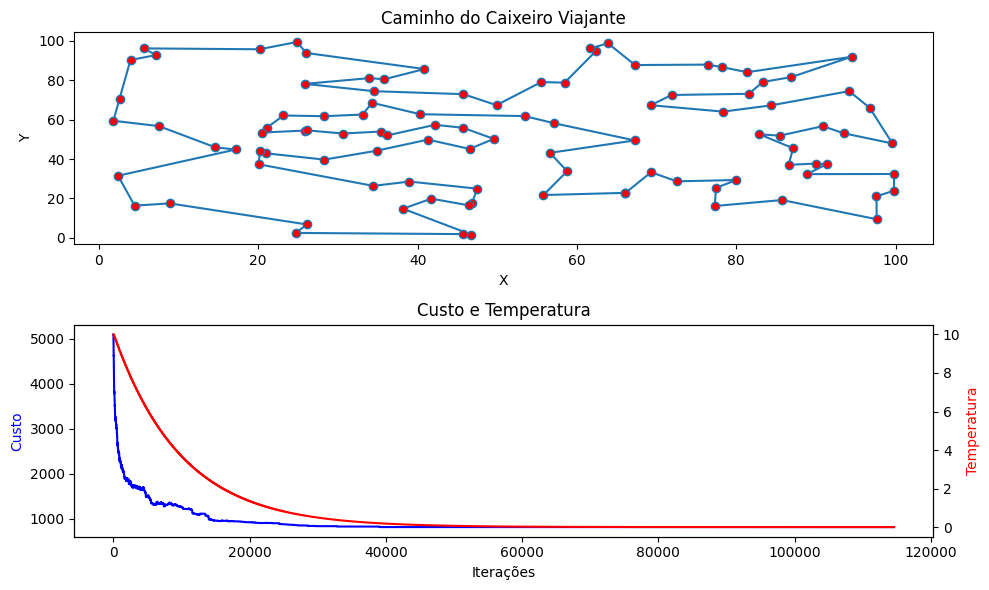

Calculado att48
Custo mínimo encontrado (att48): 33632.1272277832
Diferença em relação ao custo ótimo (att48): 316.45%


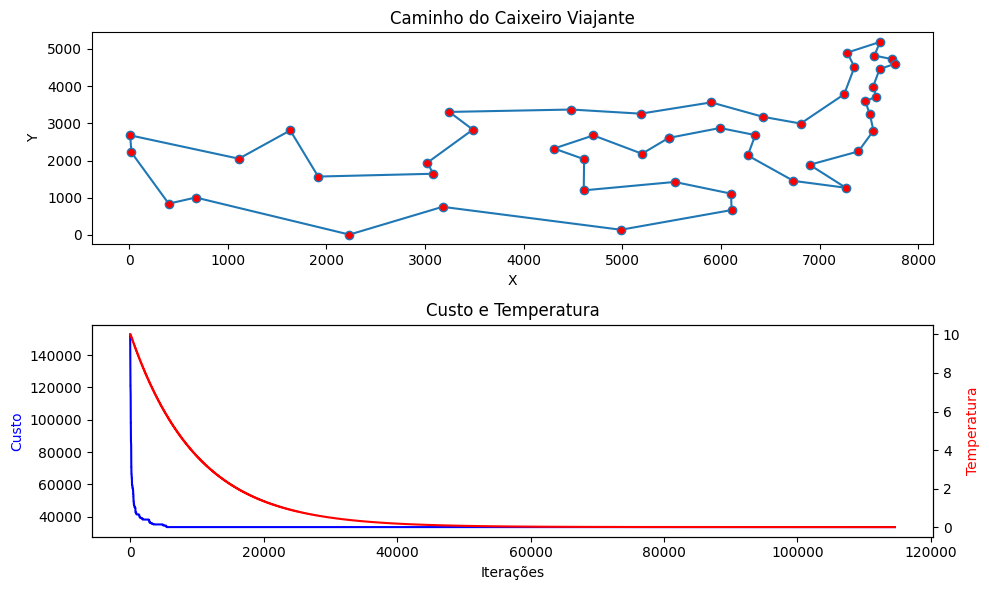

Calculado ch150
Custo mínimo encontrado (ch150): 6951.741636276245
Diferença em relação ao custo ótimo (ch150): 106.49%


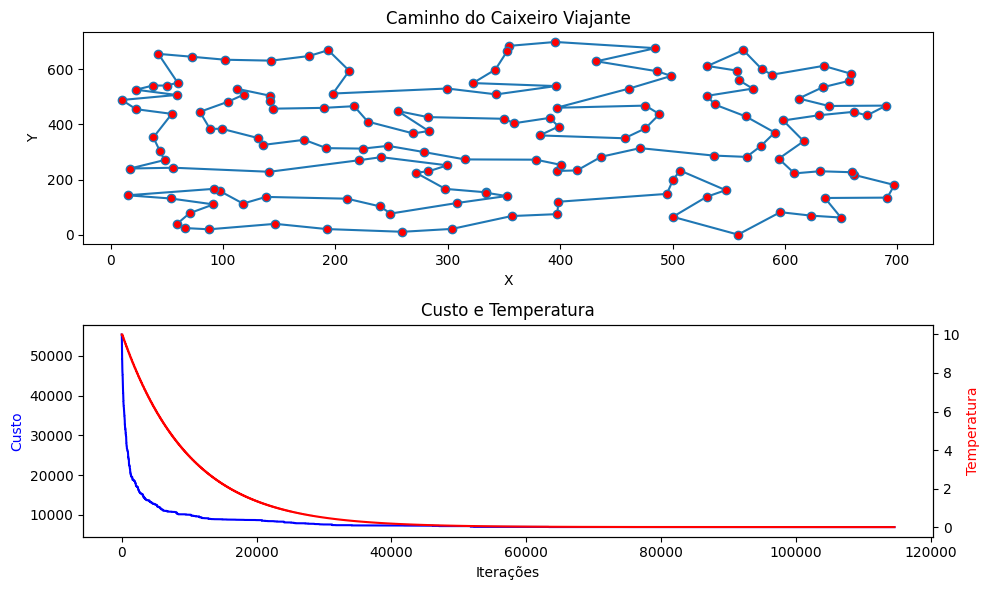

Calculado pr107
Custo mínimo encontrado (pr107): 45158.23718261719
Diferença em relação ao custo ótimo (pr107): 101.93%


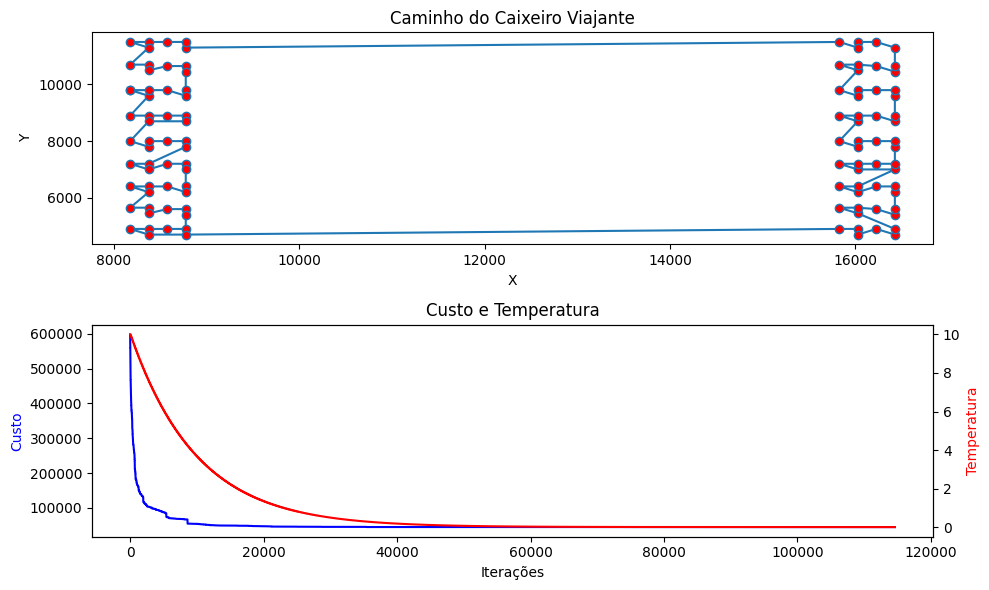

In [ ]:
# Parâmetros recomendados pelo professor
T = 10            # Temperatura inicial
tFinal = 0.0001   # Temperatura final
dT = 0.99         # Taxa de resfriamento
passos = 50       # Número de passos do algoritmo de Metrópolis

# Teste com 100 pontos aleatórios
rng = np.random.default_rng(seed=15)
x_random = rng.uniform(0, 100, 100) 
y_random = rng.uniform(0, 100, 100)

# Executa o experimento para os pontos aleatórios
custos_random, caminho_random = experimento(x_random, y_random, T, tFinal, dT, passos)
print('Calculado para pontos aleatórios')
print(f'Custo mínimo encontrado (Aleatórios): {custos_random[-1]}')
plotaCaminhoCustos(x_random, y_random, caminho_random, custos_random, T, dT)

# Teste com instâncias da TSPLIB
# 1. att48 (Ótimo: 10628)
x_att48, y_att48 = recebePontos('entradas/att48.tsp')
custosatt48, caminhoatt48 = experimento(x_att48, y_att48, T, tFinal, dT, passos)
print('Calculado att48')
print(f'Custo mínimo encontrado (att48): {custosatt48[-1]}')
print(f'Diferença em relação ao custo ótimo (att48): {round(100 * (custosatt48[-1] / 10628), 2)}%')
plotaCaminhoCustos(x_att48, y_att48, caminhoatt48, custosatt48, T, dT)

# 2. ch150 (Ótimo: 6528)
x_ch150, y_ch150 = recebePontos('entradas/ch150.tsp')
custosch150, caminhoch150 = experimento(x_ch150, y_ch150, T, tFinal, dT, passos)
print('Calculado ch150')
print(f'Custo mínimo encontrado (ch150): {custosch150[-1]}')
print(f'Diferença em relação ao custo ótimo (ch150): {round(100 * (custosch150[-1] / 6528), 2)}%')
plotaCaminhoCustos(x_ch150, y_ch150, caminhoch150, custosch150, T, dT)

# 3. pr107 (Ótimo: 44303)
x_pr107, y_pr107 = recebePontos('entradas/pr107.tsp')
custospr107, caminhopr107 = experimento(x_pr107, y_pr107, T, tFinal, dT, passos)
print('Calculado pr107')
print(f'Custo mínimo encontrado (pr107): {custospr107[-1]}')
print(f'Diferença em relação ao custo ótimo (pr107): {round(100 * (custospr107[-1] / 44303), 2)}%')
plotaCaminhoCustos(x_pr107, y_pr107, caminhopr107, custospr107, T, dT)

### Resultados do Testes Realizados

O desempenho do algoritmo foi satisfatório na maioria dos testes com instâncias do TSPLIB, especialmente nos testes 2 e 3, que apresentaram resultados bastante próximos dos valores ótimos. Nestes casos, o erro relativo foi mínimo, indicando que o algoritmo consegue encontrar boas aproximações do caminho ideal dentro de um número razoável de iterações. No entanto, o primeiro teste, utilizando a instância com 100 pontos aleatórios, apresentou um resultado surpreendentemente distante do custo ótimo esperado, o que gerou certa perplexidade.

A análise do gráfico de evolução do custo revelou que, após cerca de 10.000 iterações, o valor do custo se estabilizou e não sofreu mais alterações significativas. Embora o caminho gerado não parecesse excessivamente longo ou irracional à primeira vista, o custo final ficou muito acima do valor ótimo esperado. Esse comportamento anômalo foi observado mesmo após ajustes nos parâmetros do algoritmo, como aumentar a temperatura inicial para T=15, reduzir ainda mais a temperatura final (Tf=0.0001), e aumentar a taxa de resfriamento para dT=0.999. No entanto, esses ajustes não trouxeram uma melhoria substancial, resultando em um erro superior a 300% em relação ao valor ótimo.

Apesar desse comportamento atípico no primeiro teste, os resultados dos testes 2 e 3 demonstram que o algoritmo tem um bom potencial para encontrar soluções de qualidade em instâncias do TSPLIB, especialmente para problemas maiores e mais complexos. A eficiência do método também se destaca, já que a utilização da biblioteca Numba permitiu uma significativa redução no tempo de execução, passando de aproximadamente 2 minutos para menos de 10 segundos, o que é uma melhoria notável, principalmente para instâncias de maior tamanho.

Esses resultados são promissores e indicam que, com ajustes mais refinados nos parâmetros, o algoritmo tem o potencial de gerar soluções cada vez mais precisas e eficientes.